In [1]:
# # ------------------------------ ATTENTION ------------------------------ ##
# # You need to install the nptyping package (>>> pip install nptyping)
# # for numpy type indicators
# # ====================================================================== ##

---
# Multicell Profile
---

Import of the `Secao2D` class from the `FEM_Secao2D` package. 

In the future we want to segment the file so that classes such as 1D elements, 2D elements, structural elements, static models and dynamic models are in separate files and possibly separate packages.

In [2]:
import sys
sys.path.append('../sources')
sys.path.append('../mesh_files')

In [3]:
# import of
from FEM_Secao2D import Secao2D

Mesh file import. 

The first file is a mesh that contains 88 quadrilateral elements with 9 nodes, and the second contains 2244 to test the accuracy and efficiency of the code.

In [4]:
# # Mesh a multicell profile

# #88 elements
from mult_Q9_88e import dados    # 1 element in esp

# #2244 elements
# from Malhas.mult_Q9_2244e import data # 11 elem in esp

In [5]:
# # 'Unpacking' the mesh data
# Mesh geometry
secNodes    = dados['coordinates'] * 1e2                # Node coordinates
secElems    = dados['elements']                         # Mesh Connectivity

# Material properties
secYoung    = dados['materials'][:,0]                   # Modulus of elasticity
secNu       = dados['materials'][:,1]                   # Poisson's ratio
secRho      = dados['materials'][:,2]                   # Specific mass

Creation of the cross section instance.

When creating the instance, the cross-section warping problem is solved and the area and inertia properties are calculated. (see `FEM_Secao2D.py` from line 1188)

In [6]:
# Creating an instance of a Secao2D
sec = Secao2D(coordenadas = secNodes,
              conectividade = secElems,
              young = secYoung,
              nu = secNu,
              rho = secRho,
              grauInteg = 5)

Printing some results

In [7]:
# Area Properties
sec.propsArea

{'A_pond': 19284.423848125007,
 'Qy_pond': -1.0354785033115377,
 'Qz_pond': 98241.10913461074,
 'Iyy_pond': 79032039.03839687,
 'Izz_pond': 84957877.43624237,
 'Iyz_pond': 43.99970693880459,
 'Y_CG_pond': 5.09432430589118,
 'Z_CG_pond': -5.369507077144104e-05,
 'Iyy_pond_cent': 79032039.03834127,
 'Izz_pond_cent': 84457405.36614022,
 'Iyz_pond_cent': 49.27477024645238,
 'Y_CT': -2.4559177233885436,
 'Z_CT': -0.00010055105375019737,
 'c_CT': -3460.535340318411,
 'Jphi': 63227431.55635998,
 'Jphi_pond_G': 123721223.3514303,
 'Jphi_pond_E': 118053093.38959436,
 'Qy_cent_pond': -5.184119800105691e-11,
 'Qz_cent_pond': 9.458744898438454e-11,
 'Iyz_cent_pond': 49.27477022916719}

### Plots of some results


Distribution of the warping function

(-100.0, 100.0, -100.0, 100.0)

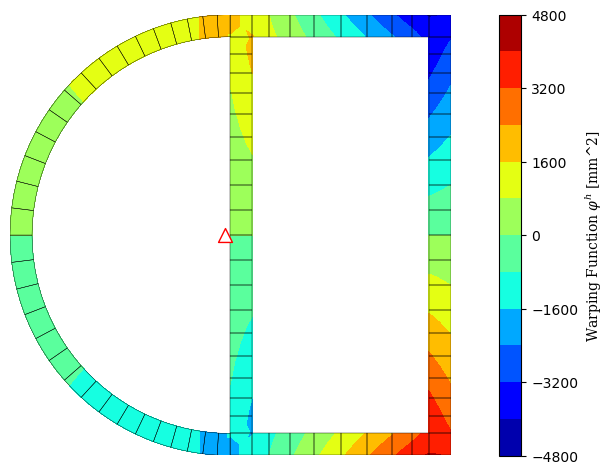

In [10]:
fig, ax = sec.plotPhi(niveis=12, mostrarMalha=True, num=2, unit='mm', figsize=(10,5))
ax.axis('off')

Shear stress distribution

Max. magnitude: 12640130041727.28
Med. magnitude: 4981984205682.008
Min. magnitude: 792848613221.7156


(-110.0, 110.0, -110.0, 110.0)

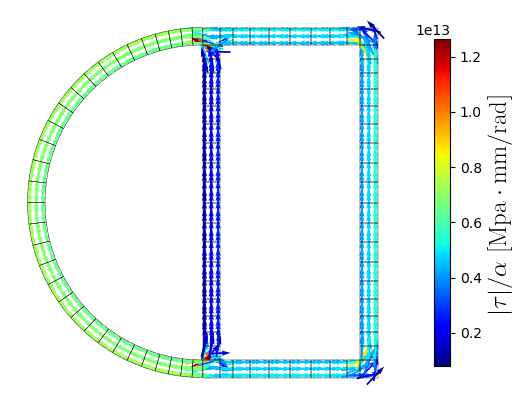

In [11]:
fig2, ax2 = sec.plotTensoesCis(width=1,scale=.07,grau=4, figsize=(10,5), cbarKwargs=dict(shrink=.85))
ax2.axis('off')